 # High-Risk Pregnancy Prediction Pipeline
 Hybrid ML + Feature Selection + Hyperparameter Optimization + XAI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE, chi2, mutual_info_classif



import warnings
warnings.filterwarnings("ignore")

/Users/akshata/Desktop/JupyterLab/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## 1. Load Dataset

In [2]:
df = pd.read_csv("BaseDataset.csv")
df = df.dropna(subset=["Risk Level"])

target = "Risk Level"
X = df.drop(columns=[target])
y = df[target]

# encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Target mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

Target mapping: {'High': np.int64(0), 'Low': np.int64(1)}


 ## 2. Preprocessing

In [3]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder="drop"
)

 ## 3. Baseline Models

In [4]:
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "RF": RandomForestClassifier(random_state=42),
    "XGB": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
    "GB": GradientBoostingClassifier()
}

results = {}
probas={}
for name, model in models.items():
    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ml_proba = clf.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    probas[name] = ml_proba

    print(f"{name} Accuracy: {acc:.4f}")
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, digits=4))
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\nOverall Model Performance:")
print(results_df)

LogReg Accuracy: 0.9706
Classification Report for LogReg:

              precision    recall  f1-score   support

           0     0.9783    0.9474    0.9626        95
           1     0.9658    0.9860    0.9758       143

    accuracy                         0.9706       238
   macro avg     0.9720    0.9667    0.9692       238
weighted avg     0.9707    0.9706    0.9705       238

RF Accuracy: 0.9958
Classification Report for RF:

              precision    recall  f1-score   support

           0     1.0000    0.9895    0.9947        95
           1     0.9931    1.0000    0.9965       143

    accuracy                         0.9958       238
   macro avg     0.9965    0.9947    0.9956       238
weighted avg     0.9958    0.9958    0.9958       238

XGB Accuracy: 0.9958
Classification Report for XGB:

              precision    recall  f1-score   support

           0     1.0000    0.9895    0.9947        95
           1     0.9931    1.0000    0.9965       143

    accuracy       

## Applying Clinical Thresholds

In [5]:
def clinical_rules(X, classes):
    proba = np.zeros((len(X), len(classes)))
    idx_low = np.where(classes == 0)[0][0] if 0 in classes else None
    idx_high = np.where(classes == 1)[0][0] if 1 in classes else None

    for i in range(len(X)):
        sbp = X.iloc[i]["Systolic BP"]
        dbp = X.iloc[i]["Diastolic"]
        bs = X.iloc[i]["BS"]
        temp = X.iloc[i]["Body Temp"]
        bmi = X.iloc[i]["BMI"]
        hr = X.iloc[i].get("HR", np.nan)     # optional
        preD = X.iloc[i].get("PreDiabetes", 0)
        gdm = X.iloc[i].get("GDM", 0)
        prev = X.iloc[i].get("PrevComplications", 0)
        mh = X.iloc[i].get("MH", 0)

        high_flags = 0
        moderate_flags = 0

        # High-risk thresholds
        if pd.notna(sbp) and sbp >= 140: high_flags += 1
        if pd.notna(dbp) and dbp >= 90:  high_flags += 1
        if pd.notna(bs) and bs >= 7.8:   high_flags += 1
        if pd.notna(bmi) and bmi >= 35:  high_flags += 1
        if pd.notna(temp) and temp >= 100.4: high_flags += 1
        if pd.notna(hr) and (hr >= 110 or hr <= 50): high_flags += 1
        if preD == 1 or gdm == 1: high_flags += 1
        if prev == 1: high_flags += 1

        # Moderate thresholds
        if pd.notna(sbp) and 130 <= sbp < 140: moderate_flags += 1
        if pd.notna(dbp) and 85 <= dbp < 90:   moderate_flags += 1
        if pd.notna(bs) and 6.7 <= bs < 7.8:   moderate_flags += 1
        if pd.notna(bmi) and 30 <= bmi < 35:   moderate_flags += 1
        if mh == 1: moderate_flags += 1

        
        base = np.ones(len(classes), dtype=float) / len(classes)

        if high_flags >= 1 and idx_high is not None:
            base *= 0.2
            base[idx_high] = 0.8
        elif moderate_flags >= 2 and idx_high is not None and idx_low is not None:
            base *= 0.2
            base[idx_high] = 0.6
            base[idx_low]  = 0.2
        elif idx_low is not None:
            base *= 0.2
            base[idx_low] = 0.8

        proba[i] = base

    return proba



In [6]:
hybrid_results = {}

for name, model in models.items():
    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    clf.fit(X_train, y_train)

    ml_proba = clf.predict_proba(X_test.reset_index(drop=True))
    rules_proba = clinical_rules(X_test.reset_index(drop=True), le.classes_)

    # Dynamic alpha: if rules say "strong high risk", use higher weight
    hybrid_proba = np.zeros_like(ml_proba)
    for i in range(len(X_test)):
        if rules_proba[i].max() >= 0.8:   # strong rule → trust rules more
            alpha = 0.7
        elif rules_proba[i].max() >= 0.6: # moderate → balance
            alpha = 0.5
        else:                             # weak rule → trust ML more
            alpha = 0.2

        hybrid_proba[i] = alpha * rules_proba[i] + (1 - alpha) * ml_proba[i]

    hybrid_pred = hybrid_proba.argmax(axis=1)
    hyb_acc = accuracy_score(y_test, hybrid_pred)

    hybrid_results[name] = hyb_acc
    print("="*60)
    print(f"{name} Hybrid Accuracy (Dynamic α): {hyb_acc:.4f}")
    print(classification_report(y_test, hybrid_pred, target_names=le.classes_))

LogReg Hybrid Accuracy (Dynamic α): 0.9706
              precision    recall  f1-score   support

        High       0.98      0.95      0.96        95
         Low       0.97      0.99      0.98       143

    accuracy                           0.97       238
   macro avg       0.97      0.97      0.97       238
weighted avg       0.97      0.97      0.97       238

RF Hybrid Accuracy (Dynamic α): 0.9958
              precision    recall  f1-score   support

        High       1.00      0.99      0.99        95
         Low       0.99      1.00      1.00       143

    accuracy                           1.00       238
   macro avg       1.00      0.99      1.00       238
weighted avg       1.00      1.00      1.00       238

XGB Hybrid Accuracy (Dynamic α): 0.9958
              precision    recall  f1-score   support

        High       1.00      0.99      0.99        95
         Low       0.99      1.00      1.00       143

    accuracy                           1.00       238
   mac

 ## 4. Stacking & Voting (Hybrid Models)

In [7]:
estimators = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(eval_metric="logloss", use_label_encoder=False))
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)

voting = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

hybrid_models = {"Stacking": stacking, "Voting": voting}

for name, model in hybrid_models.items():
    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Stacking Accuracy: 0.9916
Voting Accuracy: 0.9916


 ## 5. Feature Selection 

### XG Boost

In [8]:
def xgb_importance(X, y):
    model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
    model.fit(X, y)
    return model.feature_importances_

### Recursive Feature Elimination

In [9]:

# -------------------------------
# 2. RFE Wrapper
# -------------------------------
def rfe_selection(X, y, n_features=10):
    base = RandomForestClassifier(random_state=42)
    selector = RFE(base, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return selector.support_, selector.ranking_


### Genetic Algorithm

In [10]:

def ga_feature_selection(X, y, generations=10, population_size=8):
    def fitness(features):
        model = RandomForestClassifier(random_state=42)
        model.fit(X.iloc[:, features], y)
        return accuracy_score(y, model.predict(X.iloc[:, features]))

    n_features = X.shape[1]
    population = [random.sample(range(n_features), n_features//2) for _ in range(population_size)]

    for _ in range(generations):
        scores = [fitness(ind) for ind in population]
        sorted_idx = np.argsort(scores)[::-1]
        survivors = [population[i] for i in sorted_idx[:population_size//2]]
        new_pop = survivors.copy()
        while len(new_pop) < population_size:
            p1, p2 = random.sample(survivors, 2)
            child = list(set(p1[:len(p1)//2] + p2[len(p2)//2:]))
            if random.random() < 0.2:
                child.append(random.randint(0, n_features-1))
            new_pop.append(list(set(child)))
        population = new_pop

    best = max(population, key=fitness)
    return best


### Particle Swarm Optimization

In [11]:

def pso_feature_selection(X, y, n_particles=10, iterations=10):
    n_features = X.shape[1]
    particles = np.random.randint(0, 2, size=(n_particles, n_features))
    velocities = np.random.rand(n_particles, n_features)
    personal_best = particles.copy()
    global_best = particles[0].copy()

    def fitness(mask):
        cols = np.where(mask == 1)[0]
        if len(cols) == 0:
            return 0
        model = RandomForestClassifier(random_state=42)
        model.fit(X.iloc[:, cols], y)
        return accuracy_score(y, model.predict(X.iloc[:, cols]))

    best_score = 0
    for i in range(n_particles):
        score = fitness(particles[i])
        if score > best_score:
            best_score = score
            global_best = particles[i].copy()

    for _ in range(iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = velocities[i] + r1*(personal_best[i]-particles[i]) + r2*(global_best-particles[i])
            particles[i] = (np.random.rand(n_features) < 1/(1+np.exp(-velocities[i]))).astype(int)

            score = fitness(particles[i])
            if score > fitness(personal_best[i]):
                personal_best[i] = particles[i].copy()
            if score > best_score:
                best_score = score
                global_best = particles[i].copy()

    return np.where(global_best == 1)[0]


### Chi-Square

In [12]:


def chi2_selection(X, y):
    X_filled = SimpleImputer(strategy="median").fit_transform(X)
    # MinMax scaling to ensure non-negative
    X_scaled = MinMaxScaler().fit_transform(X_filled)
    scores, _ = chi2(X_scaled, y)
    return scores

### Mutual Imformation

In [13]:
def mi_selection(X, y):
    
    X_filled = SimpleImputer(strategy="median").fit_transform(X)
    X_scaled = MinMaxScaler().fit_transform(X_filled)
    scores = mutual_info_classif(X_scaled, y, random_state=42)
    return scores


### SHAP

In [14]:


def shap_importance(X, y):
    model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
    model.fit(X, y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    return np.abs(shap_values).mean(axis=0)


### Permutation Importance

In [15]:

def permutation_importance_scores(X, y):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    return result.importances_mean

## Output of all Feature Importance

In [16]:

def run_all_feature_selection(X, y):
    results = pd.DataFrame({"Feature": X.columns})

    # 1. XGBoost Embedded
    results["XGB"] = xgb_importance(X, y)

    # 2. RFE
    support, ranking = rfe_selection(X, y, n_features=10)
    results["RFE_Ranking"] = ranking
    results["RFE_Selected"] = support

    # 3. GA
    ga_features = ga_feature_selection(X, y)
    results["GA_Selected"] = results.index.isin(ga_features).astype(int)

    # 4. PSO
    pso_features = pso_feature_selection(X, y)
    results["PSO_Selected"] = results.index.isin(pso_features).astype(int)

    # 5. Chi-Square
    results["Chi2"] = chi2_selection(X, y)

    # 6. Mutual Information
    results["MI"] = mi_selection(X, y)

    # 7. SHAP
    results["SHAP"] = shap_importance(X, y)

    # 8. Permutation Importance
    results["Permutation"] = permutation_importance_scores(X, y)

    return results


feature_results = run_all_feature_selection(X_train, y_train)

# Show all results
print("\n=== Feature Selection Results ===\n")
print(feature_results)

# If you want sorted by any method (e.g. SHAP):
print("\n=== Top Features by SHAP ===\n")
print(feature_results.sort_values("SHAP", ascending=False).head(10))


=== Feature Selection Results ===

                   Feature       XGB  RFE_Ranking  RFE_Selected  GA_Selected  \
0                      Age  0.011786            1          True            0   
1              Systolic BP  0.017750            1          True            0   
2                Diastolic  0.006036            1          True            1   
3                       BS  0.243390            1          True            1   
4                Body Temp  0.019006            2         False            0   
5                      BMI  0.100891            1          True            0   
6   Previous Complications  0.037150            1          True            0   
7     Preexisting Diabetes  0.132755            1          True            1   
8     Gestational Diabetes  0.236415            1          True            0   
9            Mental Health  0.076441            1          True            1   
10              Heart Rate  0.118379            1          True            1   

   

 ## 6. Hyperparameter Optimization 

### Bayesian Search

In [18]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier

# Define search space
search_space = {
    "n_estimators": Integer(50, 300),
    "max_depth": Integer(3, 15),
    "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "subsample": Real(0.5, 1.0)
}

# Initialize BayesSearchCV
opt_bayes = BayesSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    search_spaces=search_space,
    n_iter=30,          # number of parameter settings to try
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

opt_bayes.fit(X_train, y_train)

print("Best params (Bayesian):", opt_bayes.best_params_)
print("Best CV score (Bayesian):", opt_bayes.best_score_)
print("Test Accuracy (Bayesian):", opt_bayes.score(X_test, y_test))


Best params (Bayesian): OrderedDict({'learning_rate': 0.29947261130592023, 'max_depth': 5, 'n_estimators': 261, 'subsample': 0.7901008334782119})
Best CV score (Bayesian): 0.986299081035923
Test Accuracy (Bayesian): 0.9915966386554622


 ## 7. Explainable AI (XAI)

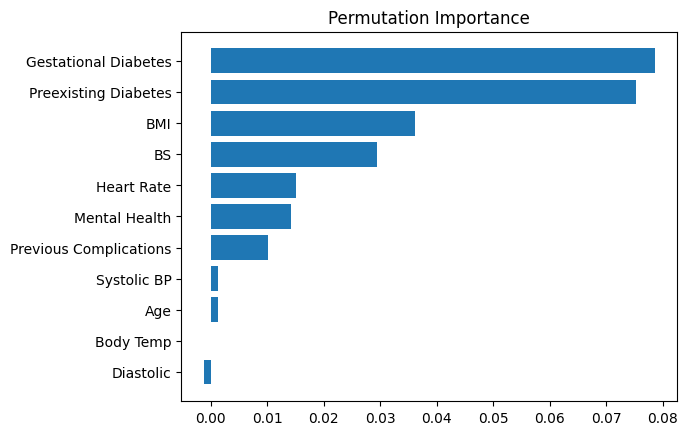

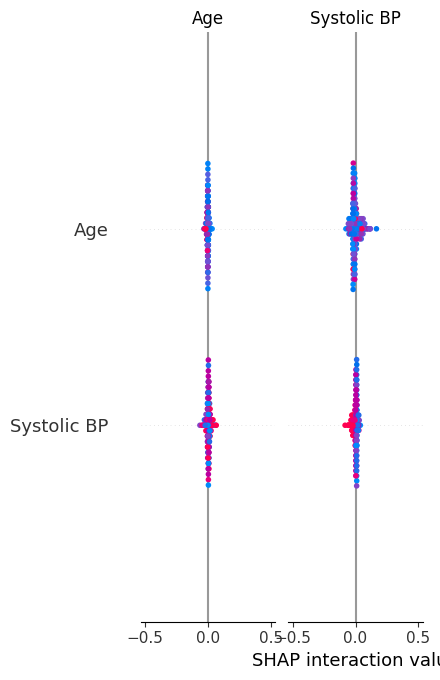

In [19]:
final_model = Pipeline(steps=[("preprocess", preprocess), ("model", RandomForestClassifier(random_state=42))])
final_model.fit(X_train, y_train)

# Permutation Importance
perm = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), perm.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(numeric_features)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

# SHAP values
explainer = shap.TreeExplainer(final_model.named_steps["model"])
X_transformed = preprocess.transform(X_test)
shap_values = explainer.shap_values(X_transformed)

shap.summary_plot(shap_values, X_transformed, feature_names=numeric_features)